In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# use inspector to see what coloumns in each table
inspector=inspect(engine)

In [10]:
columns=inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns=inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
#last 12 month: 2016-08-23 to 2018-08-23
query_start_date=dt.date(2017,8,23)-dt.timedelta(days=365)
results=session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date<='2017-08-23').\
        filter(Measurement.date>=query_start_date).all()
date_list=[]
rain_list=[]
for result in results:
    (date, rain)=result
    date_list.append(date)
    rain_list.append(rain)
rain_df=pd.DataFrame({'Date':date_list, 'Precipitation':rain_list})
rain_df.head()
sort_rain_df=rain_df.sort_values(['Date'])
new_rain_df=sort_rain_df.set_index(['Date'])
new_rain_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


![precipitation](Images/precipitation.png)

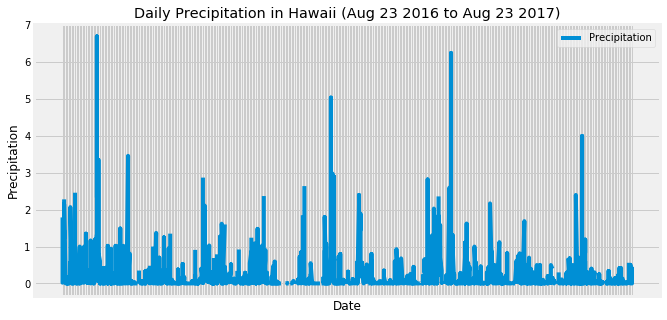

In [15]:
plt.figure(figsize=(10,5))
plt.plot(new_rain_df['Precipitation'], label='Precipitation')
# hide x-axis ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Daily Precipitation in Hawaii (Aug 23 2016 to Aug 23 2017)' )
plt.legend(loc="best")
plt.savefig('Daily_Precipitation_in_Hawaii_last_12_months.png')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
new_rain_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(func.count(Measurement.station.distinct())).all()
print(station_count)

[(9,)]


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station=session.query(Measurement.station.distinct(),func.count(Measurement.tobs)).\
               group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
for station in active_station:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
     filter(Measurement.station=='USC00519281').all()
print(temp)

[(54.0, 85.0, 71.66378066378067)]


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results=session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date<='2017-08-23').\
        filter(Measurement.date>=query_start_date).\
        filter(Measurement.station=='USC00519281').all()
t_date_list=[]
temp_list=[]
for result in results:
    (t_date, temp)=result
    t_date_list.append(t_date)
    temp_list.append(temp)
temp_df=pd.DataFrame({'Date':t_date_list, 'Temperature':temp_list})
temp_df.head()

,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


![precipitation](Images/station-histogram.png)

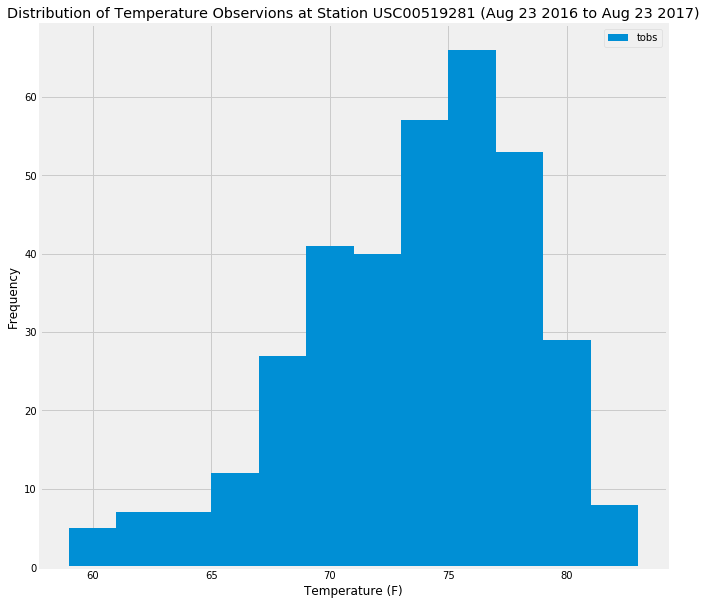

In [21]:
plt.figure(figsize=(10,10))
plt.hist(temp_df['Temperature'],bins=12,label='tobs')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature Observions at Station USC00519281 (Aug 23 2016 to Aug 23 2017)')
plt.legend(loc='best')
plt.savefig('histogram.png')
plt.show()

In [22]:
# calculate avg temp in hawaii in June
temp_list=[]
date_list=[]
results=session.query(Measurement.date, func.avg(Measurement.tobs)).\
        filter(func.strftime('%m',Measurement.date)=='06').\
        group_by(Measurement.date).all()
for i in results:
    (date,temp)=i
    temp_list.append(temp)
    date_list.append(date)
june_df=pd.DataFrame({'Date':date_list,"Jun Avg Temp":temp_list})
# extract year and day and store in two columns respectively
june_df['Year']=pd.DatetimeIndex(june_df['Date']).year
june_df['Day']=pd.DatetimeIndex(june_df['Date']).day
# concatenate year and day to form a new column, convert to string type before concatenation
june_df['Year Day']=june_df['Year'].astype(str)+'_'+june_df['Day'].astype(str)
new_june_df=june_df[['Year Day','Jun Avg Temp']]
new_june_df.head()

,Year Day,Jun Avg Temp
0,2010_1,73.555556
1,2010_2,74.555556
2,2010_3,74.444444
3,2010_4,72.888889
4,2010_5,76.000000


In [23]:
# calculate avg temp in hawaii in December
temp_list=[]
date_list=[]
results=session.query(Measurement.date, func.avg(Measurement.tobs)).\
        filter(func.strftime('%m',Measurement.date)=='12').\
        group_by(Measurement.date).all()
for i in results:
    (date,temp)=i
    temp_list.append(temp)
    date_list.append(date)
dec_df=pd.DataFrame({'Date':date_list,"Dec Avg Temp":temp_list})
# extract year and day to put into two separete columns
dec_df['Year']=pd.DatetimeIndex(dec_df['Date']).year
dec_df['Day']=pd.DatetimeIndex(dec_df['Date']).day
# change type and concatenate year and day to form a new column
dec_df['Year Day']=dec_df['Year'].astype(str)+'_'+dec_df['Day'].astype(str)
new_dec_df=dec_df[['Year Day','Dec Avg Temp']]
new_dec_df.head()

,Year Day,Dec Avg Temp
0,2010_1,73.125000
1,2010_2,72.500000
2,2010_3,71.875000
3,2010_4,74.857143
4,2010_5,71.285714


In [24]:
# Do a paired t test. since it's two measurements on the same spot at differnt time, it meets the definition of pair t test.
#pair t test reqires the two colomns (before and after) have one to one mapping.
# In order to do a paired T test, inner join two tables.
# each row contains avg temp of jun vs dec on the same day and the same year
jun_dec_df=pd.merge(new_june_df, new_dec_df,on='Year Day')
jun_dec_df.head()

,Year Day,Jun Avg Temp,Dec Avg Temp
0,2010_1,73.555556,73.125000
1,2010_2,74.555556,72.500000
2,2010_3,74.444444,71.875000
3,2010_4,72.888889,74.857143
4,2010_5,76.000000,71.285714


In [25]:
_,p_value=stats.ttest_rel(jun_dec_df['Jun Avg Temp'],jun_dec_df['Dec Avg Temp'])
print(p_value)
# p value< 0.05 indicates temp significantly different btween june and dec

6.580289883689127e-41


In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# vaction from 2017-05-01 to 2017-05-15  previous year would be 2016-05-01 to 2016-05-15
pre_vac_start='2016-05-01'
pre_vac_end='2016-05-15'
est_temp=calc_temps(pre_vac_start,pre_vac_end)
print(est_temp)


[(65.0, 73.08510638297872, 79.0)]


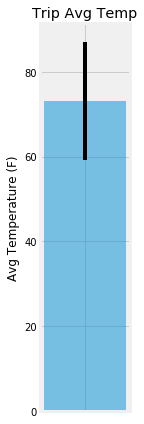

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# calc_temps()returns a list of tuple
plt.figure(figsize=(2,6))
min=est_temp[0][0]
avg=est_temp[0][1]
max=est_temp[0][2]
plt.bar('',avg,yerr=max-min,alpha=0.5,width=0.3)
plt.title('Trip Avg Temp')
plt.ylabel('Avg Temperature (F)')
plt.tight_layout()
plt.savefig('avg_temp_barplot.png')
plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results=session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.round(func.avg(Measurement.prcp),5)).\
        filter(Measurement.station==Station.station).\
        filter(Measurement.date>=pre_vac_start).\
        filter(Measurement.date<=pre_vac_end).\
        group_by(Measurement.station).\
        order_by(func.avg(Measurement.prcp).desc()).all()
print(results)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.38545), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.26), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.25333), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.22), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.204), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.11889), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.01267)]


## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
# vation from 2017-05-01 to 2017-05-15
base = dt.date(2017,5,1) # set base day (the 1st day of vaction)
# use list comprehension to create a list contains dates of 15 days from 2017-05-01 to 2017-05-15
vac_date_list = [base + dt.timedelta(days=x) for x in range(15)]
print(vac_date_list)

[datetime.date(2017, 5, 1), datetime.date(2017, 5, 2), datetime.date(2017, 5, 3), datetime.date(2017, 5, 4), datetime.date(2017, 5, 5), datetime.date(2017, 5, 6), datetime.date(2017, 5, 7), datetime.date(2017, 5, 8), datetime.date(2017, 5, 9), datetime.date(2017, 5, 10), datetime.date(2017, 5, 11), datetime.date(2017, 5, 12), datetime.date(2017, 5, 13), datetime.date(2017, 5, 14), datetime.date(2017, 5, 15)]


In [32]:
# extract month and day and use list comprehension to create a new list where each element only contains month and day
md=[i.strftime('%m-%d') for i in vac_date_list]
print(md)

['05-01', '05-02', '05-03', '05-04', '05-05', '05-06', '05-07', '05-08', '05-09', '05-10', '05-11', '05-12', '05-13', '05-14', '05-15']


In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vac_temp_list=[]
for i in md:
    rel=daily_normals(i)
    vac_temp_list.append(*rel) #daily_normals() return a list of a tuple, open it to put the tuple into a new list
print(vac_temp_list)

[(65.0, 72.75925925925925, 79.0), (65.0, 73.05084745762711, 79.0), (67.0, 73.41071428571429, 84.0), (65.0, 73.59649122807018, 78.0), (67.0, 73.39655172413794, 79.0), (66.0, 73.14035087719299, 80.0), (64.0, 71.78846153846153, 79.0), (65.0, 72.18867924528301, 80.0), (67.0, 72.9322033898305, 79.0), (64.0, 73.3157894736842, 78.0), (65.0, 73.61111111111111, 79.0), (65.0, 73.13793103448276, 79.0), (67.0, 73.14285714285714, 79.0), (63.0, 73.89285714285714, 80.0), (63.0, 73.69090909090909, 79.0)]


In [34]:
# create a dataframe from a list of tuples. have to add headers
vac_temp_df=pd.DataFrame(vac_temp_list,columns=['min','avg','max'])
vac_temp_df['date']=vac_date_list
est_vac_temp=vac_temp_df.set_index(['date'])
est_vac_temp

,min,avg,max
date,,,
2017-05-01,65.0,72.759259,79.0
2017-05-02,65.0,73.050847,79.0
2017-05-03,67.0,73.410714,84.0
2017-05-04,65.0,73.596491,78.0
2017-05-05,67.0,73.396552,79.0
2017-05-06,66.0,73.140351,80.0
2017-05-07,64.0,71.788462,79.0
2017-05-08,65.0,72.188679,80.0
2017-05-09,67.0,72.932203,79.0


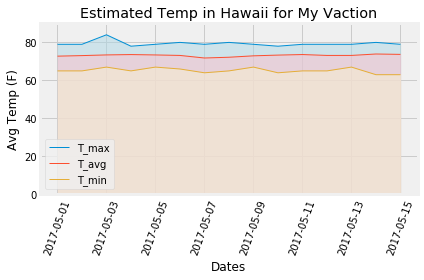

In [37]:
# use plt.plot to plot the line and plt.fill_between to fill the color
# order matters. or the fill color of max would cover the rest
plt.plot(vac_temp_df['date'],vac_temp_df['max'],lw=1,label='T_max')
plt.plot(vac_temp_df['date'], vac_temp_df['avg'],lw=1,label='T_avg')
plt.plot(vac_temp_df['date'], vac_temp_df['min'],lw=1,label='T_min')
plt.fill_between(vac_temp_df['date'],vac_temp_df['max'],color='lightblue',alpha=0.5)
plt.fill_between(vac_temp_df['date'],vac_temp_df['avg'],color='pink',alpha=0.5)
plt.fill_between(vac_temp_df['date'],vac_temp_df['min'],color='lemonchiffon',alpha=0.4)
plt.xticks(rotation=70)
plt.ylim(0,90)
plt.legend(loc='best')
plt.title('Estimated Temp in Hawaii for My Vaction')
plt.xlabel('Dates')
plt.ylabel('Avg Temp (F)')
plt.tight_layout()
plt.savefig('est_temp_vaction')
plt.show()

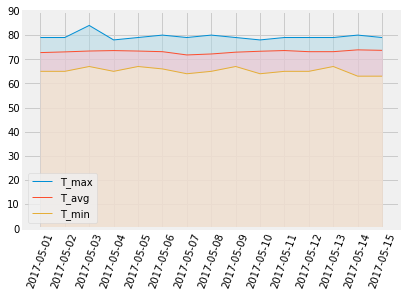

In [36]:
plt.plot(list(np.arange(15)),est_vac_temp['max'],lw=1,label='T_max')
plt.plot(list(np.arange(15)),est_vac_temp['avg'],lw=1,label='T_avg')
plt.plot(list(np.arange(15)),est_vac_temp['min'],lw=1,label='T_min')
plt.fill_between(list(np.arange(15)),est_vac_temp['max'],color='lightblue',alpha=0.5)
plt.fill_between(list(np.arange(15)),est_vac_temp['avg'],color='pink',alpha=0.5)
plt.fill_between(list(np.arange(15)),est_vac_temp['min'],color='lemonchiffon',alpha=0.4)
plt.xticks(list(np.arange(15)),vac_date_list, rotation=70)
plt.ylim(0,90)
plt.legend(loc='best')